# Практика 3.2: улучшение дерева решений и разные критерии нечистоты

В этой тетрадке мы продолжаем работать с деревом решений, которое реализовали ранее "с нуля".

Напомним, что в базовой версии дерева:

- задача была только бинарной классификацией с метками $0$ и $1$;
- в каждом узле мы использовали индекс Джини как меру нечистоты:
  $$G = 1 - p^2 - (1 - p)^2,$$
  где $p$ — доля объектов класса $1$ в узле;
- в листе дерево возвращало только жёсткое предсказание класса (без вероятностей);
- рост дерева контролировался только глубиной $\text{max\_depth}$ и минимальным числом объектов в узле $\text{min\_samples\_split}$.

В этой тетрадке мы:

1. Обобщим понятие нечистоты узла на многоклассовый случай.
2. Введём **энтропию** как альтернативный критерий нечистоты и сравним её с индексом Джини.
3. Реализуем улучшенную версию дерева, которая:
   - поддерживает многоклассовую классификацию,
   - умеет возвращать вероятностные предсказания (`predict_proba`),
   - может использовать в качестве критерия либо Джини, либо энтропию,
   - имеет дополнительный критерий остановки по уменьшению нечистоты (`min_impurity_decrease`).
4. На примерах покажем, как влияют эти улучшения на поведение дерева и его сложность.


In [55]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True


## 1. Нечистота узла в многоклассовом случае: Джини и энтропия

Ранее мы рассматривали только бинарный случай, когда $y \in \{0, 1\}$. Тогда доля класса $1$ в узле равна $p$, доля класса $0$ — $1 - p$, и индекс Джини задаётся формулой

$$G = 1 - p^2 - (1 - p)^2.$$

В многоклассовом случае, когда классы $y \in \{0, 1, \dots, K - 1\}$, в узле есть доли $p_k$ объектов каждого класса $k$:

$$p_k = \dfrac{n_k}{n},$$

где $n_k$ — число объектов класса $k$ в узле, а $n$ — общее число объектов в узле.

Тогда индекс Джини обобщается так:

$$G = 1 - \sum_{k=0}^{K-1} p_k^2.$$

- Если все объекты в узле одного класса, то для некоторого $k$ имеем $p_k = 1$, а все остальные доли равны $0$, и нечистота $G = 0$ (узел чистый).
- Если классы распределены равномерно (например, три класса с долями $\tfrac{1}{3}$, $\tfrac{1}{3}$, $\tfrac{1}{3}$), то $G$ максимален.

Другой популярный критерий нечистоты — **энтропия**. Для многоклассового случая она определяется как

$$H = - \sum_{k=0}^{K-1} p_k \log_2 p_k,$$

при этом по соглашению выражение $p_k \log_2 p_k$ считается равным $0$, если $p_k = 0$.

- Энтропия тоже равна $0$, когда в узле все объекты одного класса.
- Энтропия достигает максимума, когда все классы представлены равномерно.

И индекс Джини, и энтропия измеряют "разнообразие" классов в узле. Различия в том, как они штрафуют неоднородность, но качественно они ведут себя похожим образом.


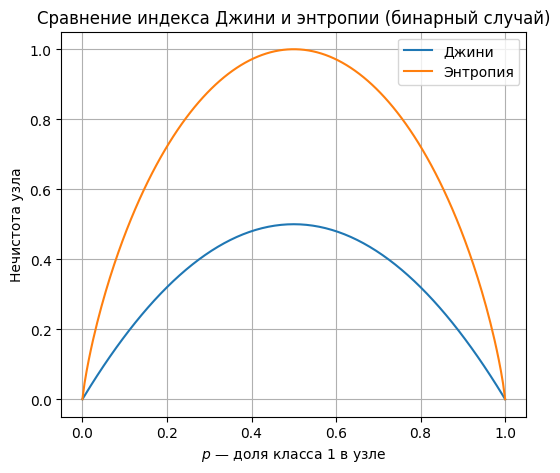

In [56]:
def gini_binary(p):
    return 1.0 - p ** 2 - (1.0 - p) ** 2


def entropy_binary(p):
    # p может быть скаляром или массивом
    p = np.asarray(p)
    # избежим log(0)
    eps = 1e-12
    p_clipped = np.clip(p, eps, 1 - eps)
    return -(p_clipped * np.log2(p_clipped) + (1.0 - p_clipped) * np.log2(1.0 - p_clipped))


ps = np.linspace(0, 1, 201)
g_vals = gini_binary(ps)
h_vals = entropy_binary(ps)

fig, ax = plt.subplots()
ax.plot(ps, g_vals, label="Джини")
ax.plot(ps, h_vals, label="Энтропия")
ax.set_xlabel("$p$ — доля класса 1 в узле")
ax.set_ylabel("Нечистота узла")
ax.set_title("Сравнение индекса Джини и энтропии (бинарный случай)")
ax.legend()
plt.show()


На графике видно, что:

- и индекс Джини, и энтропия равны $0$ при $p = 0$ и $p = 1$ (узел чистый);
- оба критерия достигают максимума при $p = 0.5$, когда классы смешаны поровну;
- кривая энтропии более "выпуклая" и растёт по-другому из-за логарифма.

На практике оба критерия ведут себя похоже: разбиения, улучшающие Джини, часто улучшают и энтропию, и наоборот.
Однако энтропия чуть сильнее реагирует на ситуации, когда один класс доминирует, а второй представлен небольшой долей.

Теперь реализуем функцию нечистоты, которая умеет работать в многоклассовом случае и поддерживает два критерия: `gini` и `entropy`.


In [57]:
def impurity(y, classes, criterion="gini") -> float:
    """Вычисление нечистоты узла для вектора меток y и заданного критерия.

    y: одномерный массив меток (может быть многоклассным),
    classes: массив всех возможных классов (например, np.unique по всей выборке),
    criterion: "gini" или "entropy".
    """
    n = len(y)
    if n == 0:
        return 0.0

    # Считаем количества объектов каждого класса в узле
    counts = np.array([(y == c).sum() for c in classes], dtype=float)
    p = counts / counts.sum()

    if criterion == "gini":
        return 1.0 - np.sum(p ** 2)
    elif criterion == "entropy":
        eps = 1e-12
        p_clipped = np.clip(p, eps, 1.0)
        return -np.sum(p_clipped * np.log2(p_clipped))
    else:
        raise ValueError(f"Неизвестный критерий: {criterion}")


# Пример: проверим, что для равномерного распределения по 3 классам нечистота максимальна
y_example = np.array([0, 0, 1, 1, 2, 2])
classes_example = np.array([0, 1, 2])
print("Gini (3 класса, поровну):", impurity(y_example, classes_example, criterion="gini"))
print("Entropy (3 класса, поровну):", impurity(y_example, classes_example, criterion="entropy"))


Gini (3 класса, поровну): 0.6666666666666667
Entropy (3 класса, поровну): 1.584962500721156


## 2. Улучшенное дерево: многоклассовость, вероятности, критерий и остановка по уменьшению нечистоты

Теперь модифицируем нашу реализацию дерева таким образом, чтобы:

1. **Поддерживать многоклассовую классификацию.**  
   В узле будем считать доли всех классов $p_k$ и использовать их в формуле Джини или энтропии.  
   В листе будем хранить вектор вероятностей классов:
   $$\hat{p}_k = \dfrac{n_k}{n},$$
   а предсказанный класс брать как $\arg\max_k \hat{p}_k$.

2. **Уметь возвращать вероятности (`predict_proba`).**  
   Для каждого объекта при обходе дерева до листа будем возвращать не только класс, но и вектор $[\hat{p}_0, \hat{p}_1, \dots, \hat{p}_{K-1}]$.

3. **Поддерживать выбор критерия нечистоты.**  
   Параметр `criterion` будет задавать, чем пользоваться при поиске разбиений:
   - `"gini"` — индекс Джини;
   - `"entropy"` — энтропия.

4. **Добавить критерий остановки по уменьшению нечистоты.**  
   Пусть $I_\text{parent}$ — нечистота узла до разбиения, а $I_\text{split}$ — средневзвешенная нечистота после разбиения:

   $$I_\text{split} = \dfrac{n_L}{n} I_L + \dfrac{n_R}{n} I_R,$$

   где $I_L$ и $I_R$ — нечистоты в левом и правом узлах. Тогда уменьшение нечистоты определяется как

   $$\Delta I = I_\text{parent} - I_\text{split}.$$

   Введём параметр `min_impurity_decrease`. Если даже лучшее разбиение даёт $\Delta I < \text{min\_impurity\_decrease}$, то узел не имеет смысла делить дальше, и мы делаем лист.

Такие расширения приближают нашу реализацию к промышленным деревьям (например, из `sklearn`), но всё ещё сохраняют простую и прозрачную структуру кода.


In [58]:
def best_split(X, y, classes, criterion="gini") -> (
        Optional[int], Optional[float], float, Optional[int], Optional[int], float
):
    """Поиск лучшего разбиения по всем признакам для заданного критерия.

    Возвращает кортеж:
    (best_feature, best_threshold, best_impurity, best_left_idx, best_right_idx, parent_impurity).
    Если разбиение не найдено, best_feature будет None.
    """
    n_samples, n_features = X.shape

    parent_impurity = impurity(y, classes, criterion)

    if n_samples <= 1:
        return None, None, parent_impurity, None, None, parent_impurity

    best_impurity = parent_impurity
    best_feature = None
    best_threshold = None
    best_left_idx = None
    best_right_idx = None

    for feature in range(n_features):
        X_column = X[:, feature]
        thresholds = np.unique(X_column)

        for threshold in thresholds:
            left_mask = X_column <= threshold
            right_mask = ~left_mask

            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            y_left = y[left_mask]
            y_right = y[right_mask]

            n_left = len(y_left)
            n_right = len(y_right)
            impurity_left = impurity(y_left, classes, criterion)
            impurity_right = impurity(y_right, classes, criterion)

            impurity_split = (n_left * impurity_left + n_right * impurity_right) / (n_left + n_right)

            if impurity_split < best_impurity:
                best_impurity = impurity_split
                best_feature = feature
                best_threshold = threshold
                best_left_idx = np.where(left_mask)[0]
                best_right_idx = np.where(right_mask)[0]

    return best_feature, best_threshold, best_impurity, best_left_idx, best_right_idx, parent_impurity


In [59]:
class Node:
    def __init__(
            self,
            feature=None, threshold=None, left=None, right=None,
            proba=None, pred_class=None,
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        # Вектор вероятностей классов в узле (в листе он особенно важен)
        self.proba = proba
        # Индекс предсказанного класса (по массиву classes_ в дереве)
        self.pred_class = pred_class

    @property
    def is_leaf(self):
        return self.left is None and self.right is None


class ImprovedDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2,
                 min_impurity_decrease=0.0, criterion="gini"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.root = None
        self.classes_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.root = self._build_tree(X, y, depth=0)

    def _node_proba_and_class(self, y):
        # Подсчёт вероятностей классов и предсказываемого класса в узле
        n = len(y)
        counts = np.array([(y == c).sum() for c in self.classes_], dtype=float)
        if n == 0:
            # Не должно происходить при корректном разбиении, но на всякий случай
            proba = np.ones(len(self.classes_)) / len(self.classes_)
        else:
            proba = counts / n
        pred_class = np.argmax(proba)
        return proba, pred_class

    def _build_tree(self, X, y, depth):
        num_samples = len(y)

        # Вероятности и базовое предсказание в узле
        proba, pred_class = self._node_proba_and_class(y)

        # Условия остановки роста дерева
        # 1. Достигнута максимальная глубина
        # 2. Мало объектов для разбиения
        # 3. Все объекты одного класса
        if (
                depth >= self.max_depth
                or num_samples < self.min_samples_split
                or np.unique(y).size == 1
        ):
            return Node(proba=proba, pred_class=pred_class)

        feature, threshold, best_impurity, left_idx, right_idx, parent_impurity = best_split(
            X, y, self.classes_, self.criterion
        )

        # Если лучшего разбиения нет или уменьшение нечистоты мало — делаем лист
        if feature is None or left_idx is None or right_idx is None:
            return Node(proba=proba, pred_class=pred_class)

        impurity_decrease = parent_impurity - best_impurity
        if impurity_decrease < self.min_impurity_decrease:
            return Node(proba=proba, pred_class=pred_class)

        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)

        return Node(feature=feature, threshold=threshold,
                    left=left_child, right=right_child,
                    proba=proba, pred_class=pred_class)

    def _predict_one(self, x, node):
        if node.is_leaf:
            return node.pred_class
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def _predict_proba_one(self, x, node):
        if node.is_leaf:
            return node.proba
        if x[node.feature] <= node.threshold:
            return self._predict_proba_one(x, node.left)
        else:
            return self._predict_proba_one(x, node.right)

    def predict(self, X):
        X = np.asarray(X)
        # Преобразуем индексы классов в реальные значения меток
        pred_indices = np.array([self._predict_one(x, self.root) for x in X])
        return self.classes_[pred_indices]

    def predict_proba(self, X):
        X = np.asarray(X)
        probs = np.array([self._predict_proba_one(x, self.root) for x in X])
        return probs


## 3. Демонстрация на многоклассовом датасете: Джини против энтропии

Сгенерируем простой двумерный датасет с тремя классами с помощью `make_blobs` и обучим на нём два дерева:

- одно с критерием `"gini"`;
- другое с критерием `"entropy"`.

Посмотрим на качество и границы решений.


In [60]:
from sklearn.datasets import load_wine

wine = load_wine()
X_full = wine["data"]  # shape (178, 13)
y = wine["target"]  # 3 класса

In [61]:
X_full[:5]

array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, 1.000e+02, 2.650e+00,
        2.760e+00, 2.600e-01, 1.280e+00, 4.380e+00, 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00,
        3.240e+00, 3.000e-01, 2.810e+00, 5.680e+00, 1.030e+00, 3.170e+00,
        1.185e+03],
       [1.437e+01, 1.950e+00, 2.500e+00, 1.680e+01, 1.130e+02, 3.850e+00,
        3.490e+00, 2.400e-01, 2.180e+00, 7.800e+00, 8.600e-01, 3.450e+00,
        1.480e+03],
       [1.324e+01, 2.590e+00, 2.870e+00, 2.100e+01, 1.180e+02, 2.800e+00,
        2.690e+00, 3.900e-01, 1.820e+00, 4.320e+00, 1.040e+00, 2.930e+00,
        7.350e+02]])

In [62]:
y[:5]

array([0, 0, 0, 0, 0])

In [63]:
# Выбираем два признака для 2D-графиков, например:
# 0 — alcohol, 1 — malic_acid
X = X_full[:, [0, 1]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

tree_gini = ImprovedDecisionTree(max_depth=5, min_samples_split=5,
                                 min_impurity_decrease=0.0, criterion="gini")
tree_entropy = ImprovedDecisionTree(max_depth=5, min_samples_split=5,
                                    min_impurity_decrease=0.0, criterion="entropy")

tree_gini.fit(X_train, y_train)
tree_entropy.fit(X_train, y_train)

y_pred_gini = tree_gini.predict(X_test)
y_pred_entropy = tree_entropy.predict(X_test)

print("Gini:    accuracy on test =", accuracy_score(y_test, y_pred_gini))
print("Entropy: accuracy on test =", accuracy_score(y_test, y_pred_entropy))


Gini:    accuracy on test = 0.6666666666666666
Entropy: accuracy on test = 0.7037037037037037


In [64]:
tree_gini.predict_proba(X_test[:5])

array([[0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.81818182, 0.18181818, 0.        ],
       [0.125     , 0.        , 0.875     ],
       [0.81818182, 0.18181818, 0.        ]])

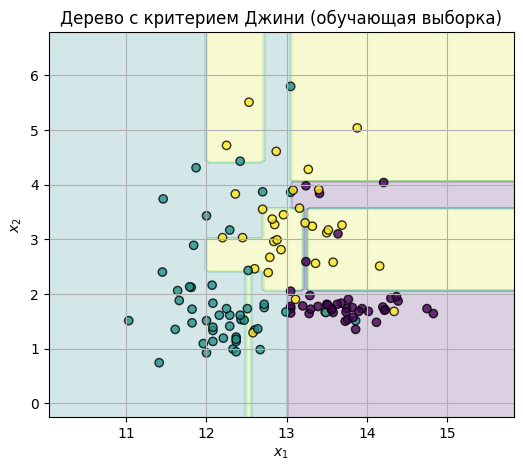

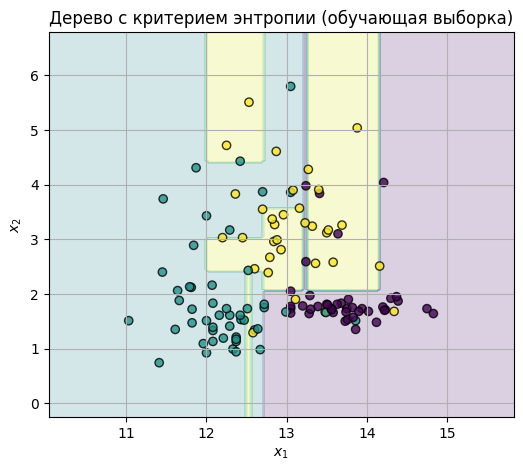

In [65]:
def plot_decision_boundary_multiclass(model, X, y, h=0.05, title=None):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.2)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", alpha=0.8)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title is not None:
        ax.set_title(title)
    plt.show()


plot_decision_boundary_multiclass(tree_gini, X_train, y_train,
                                  title="Дерево с критерием Джини (обучающая выборка)")

plot_decision_boundary_multiclass(tree_entropy, X_train, y_train,
                                  title="Дерево с критерием энтропии (обучающая выборка)")


На графиках видно, что оба дерева строят похожие нелинейные границы между тремя классами.
Часто дерево с Джини и дерево с энтропией дают очень близкое качество и визуально похожие разбиения.

Различия могут проявляться на более сложных или дисбалансных данных, но общая идея одна и та же:

- мы ищем разбиение, которое максимизирует уменьшение нечистоты $\Delta I$;
- нечистота измеряется либо индексом Джини, либо энтропией.

Теперь посмотрим, как на сложность дерева влияет параметр `min_impurity_decrease`.


## 4. Влияние параметра `min_impurity_decrease` на сложность дерева

Напомним, что уменьшение нечистоты при разбиении узла определяется как

$$\Delta I = I_\text{parent} - I_\text{split},$$

где $I_\text{parent}$ — нечистота до разбиения, а $I_\text{split}$ — средневзвешенная нечистота после разбиения.

Если даже лучшее разбиение даёт очень маленькое $\Delta I$, то такой шаг почти не улучшает качество и только усложняет дерево.
Параметр `min_impurity_decrease` позволяет запретить такие разбиения.

Построим два дерева на одном и том же датасете:

- одно без ограничения (`min_impurity_decrease = 0`),
- второе с положительным порогом (например, `min_impurity_decrease = 0.01`).

Сравним их глубину, число листьев и качество.


In [66]:
def tree_depth(node):
    if node is None or node.is_leaf:
        return 0
    return 1 + max(tree_depth(node.left), tree_depth(node.right))


def count_leaves(node):
    if node is None:
        return 0
    if node.is_leaf:
        return 1
    return count_leaves(node.left) + count_leaves(node.right)


In [67]:
# Используем тот же многоклассовый датасет X, y
tree_no_reg = ImprovedDecisionTree(max_depth=10, min_samples_split=5,
                                   min_impurity_decrease=0.0, criterion="gini")
tree_with_reg = ImprovedDecisionTree(max_depth=10, min_samples_split=5,
                                     min_impurity_decrease=0.1, criterion="gini")

tree_no_reg.fit(X_train, y_train)
tree_with_reg.fit(X_train, y_train)

y_pred_no_reg_train = tree_no_reg.predict(X_train)
y_pred_with_reg_train = tree_with_reg.predict(X_train)

y_pred_no_reg = tree_no_reg.predict(X_test)
y_pred_with_reg = tree_with_reg.predict(X_test)

depth_no_reg = tree_depth(tree_no_reg.root)
depth_with_reg = tree_depth(tree_with_reg.root)
leaves_no_reg = count_leaves(tree_no_reg.root)
leaves_with_reg = count_leaves(tree_with_reg.root)

print("Без ограничения по уменьшению нечистоты:")
print("  Глубина дерева:", depth_no_reg)
print("  Число листьев:", leaves_no_reg)
print("Метрики на трейн (без регуляризации):")
print(classification_report(y_train, y_pred_no_reg_train))
print("Метрики на тесте (без регуляризации):")
print(classification_report(y_test, y_pred_no_reg))

print("\nС min_impurity_decrease = 0.01:")
print("  Глубина дерева:", depth_with_reg)
print("  Число листьев:", leaves_with_reg)
print("Метрики на трейн (с регуляризацией):")
print(classification_report(y_train, y_pred_with_reg_train))
print("Метрики на тесте (с регуляризацией):")
print(classification_report(y_test, y_pred_with_reg))


Без ограничения по уменьшению нечистоты:
  Глубина дерева: 7
  Число листьев: 24
Метрики на трейн (без регуляризации):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        41
           1       0.98      0.94      0.96        50
           2       0.91      0.91      0.91        33

    accuracy                           0.94       124
   macro avg       0.93      0.93      0.93       124
weighted avg       0.94      0.94      0.94       124

Метрики на тесте (без регуляризации):
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.72      0.62      0.67        21
           2       0.59      0.67      0.62        15

    accuracy                           0.67        54
   macro avg       0.66      0.67      0.66        54
weighted avg       0.67      0.67      0.67        54


С min_impurity_decrease = 0.01:
  Глубина дерева: 2
  Число листьев: 3
Метрики н

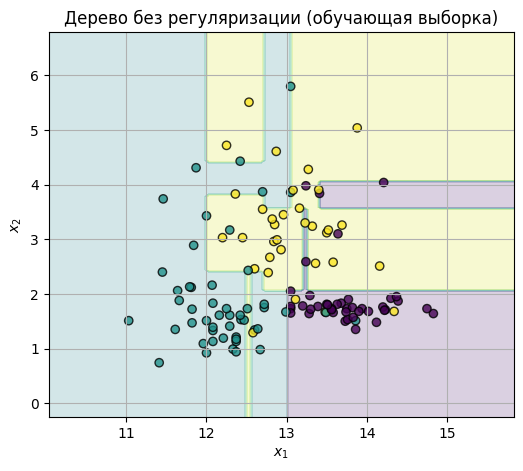

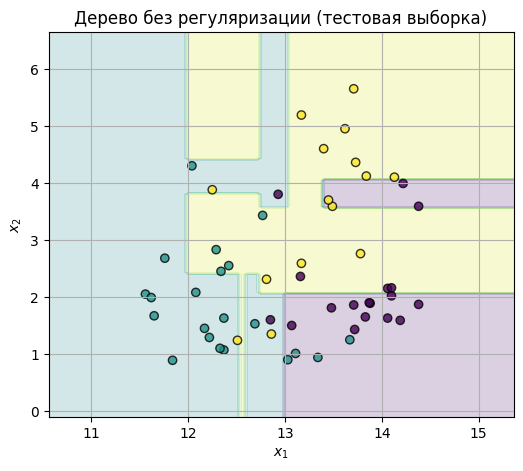

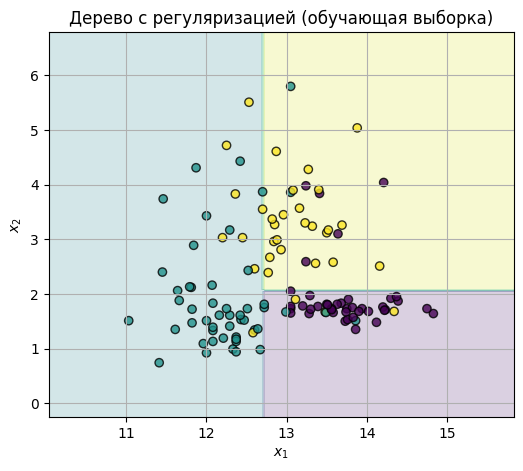

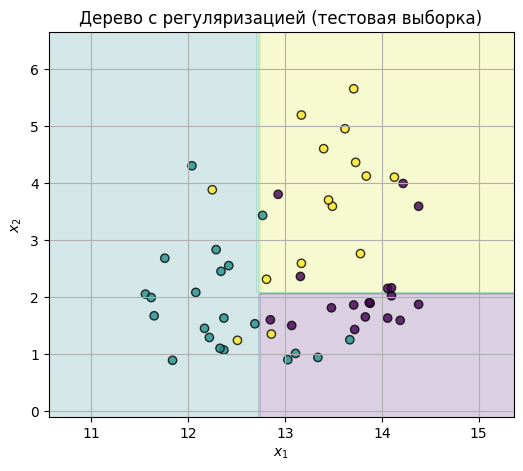

In [68]:
plot_decision_boundary_multiclass(tree_no_reg, X_train, y_train,
                                  title="Дерево без регуляризации (обучающая выборка)")

plot_decision_boundary_multiclass(tree_no_reg, X_test, y_test,
                                  title="Дерево без регуляризации (тестовая выборка)")

plot_decision_boundary_multiclass(tree_with_reg, X_train, y_train,
                                  title="Дерево с регуляризацией (обучающая выборка)")

plot_decision_boundary_multiclass(tree_with_reg, X_test, y_test,
                                  title="Дерево с регуляризацией (тестовая выборка)")


Мы видим, что введение порога по уменьшению нечистоты:

- уменьшает глубину дерева и сокращает число листьев;
- часто почти не ухудшает качество (иногда даже немного улучшает его за счёт снижения переобучения).

Этот параметр выполняет роль **регуляризатора структуры дерева**: мы запрещаем слишком "слабые" разбиения, которые дают лишь минимальное улучшение критерия, но увеличивают сложность модели.


## 5. Итоги и связь с промышленными реализациями

В этой тетрадке мы улучшили исходную реализацию дерева решений и добавили к ней несколько важных элементов:

1. **Многоклассовая поддержка.**  
   - В узле считаются доли всех классов $p_k$, нечистота узла задаётся формулами
     $$G = 1 - \sum_k p_k^2, \quad H = - \sum_k p_k \log_2 p_k.$$
   - В листе хранится вектор вероятностей классов, а предсказание — это класс с максимальной долей.

2. **Вероятностные предсказания (`predict_proba`).**  
   - Для каждого объекта можно получить вектор вероятностей классов.
   - Это позволяет использовать вероятностные метрики (ROC-кривые, ROC-AUC и т.д.) и анализировать уверенность модели.

3. **Выбор критерия нечистоты: Джини или энтропия.**  
   - Оба критерия измеряют неоднородность распределения классов в узле.
   - Джини проще вычислительно, энтропия имеет интерпретацию из теории информации.
   - На практике они часто ведут себя похоже, но могут по-разному ранжировать разбиения в тонких случаях.

4. **Критерий остановки по уменьшению нечистоты (`min_impurity_decrease`).**  
   - Если даже лучшее разбиение узла даёт слишком маленькое уменьшение нечистоты $\Delta I$, узел не делится, а становится листом.
   - Это уменьшает глубину дерева, количество листьев и помогает бороться с переобучением.

Все эти идеи используются и в промышленных реализациях деревьев, таких как `DecisionTreeClassifier` и `DecisionTreeRegressor` в `sklearn`.
Отличие в том, что библиотечные версии:

- сильно оптимизированы по скорости и потреблению памяти;
- поддерживают множество дополнительных параметров (например, `max_leaf_nodes`, `class_weight`, специальные стратегии обработки пропусков и т.п.);
- интегрированы в экосистему инструментов (пайплайны, кросс-валидация, подбор гиперпараметров).

Тем не менее, имея перед глазами простую реализацию, легче понимать, **что именно** происходит внутри дерева и ансамблей на их основе (случайных лесов, градиентного бустинга), и осмысленнее настраивать их гиперпараметры в реальных проектах.


## Дерево решений для регрессии: как адаптировать нашу реализацию

До сих пор мы рассматривали дерево решений как модель **классификации**:
- в листьях хранится предсказанный класс;
- для выбора разбиения мы используем нечистоту класса (индекс Джини или энтропию);
- критерий качества разбиения — уменьшение нечистоты.

Идея **дерева регрессии** очень похожа, но меняются роли целевой переменной и критерия.

### 1. Целевая переменная

В регрессии целевая переменная $y$ — вещественная:
- вместо меток классов $0, 1, 2, \dots$ мы имеем значения $y \in \mathbb{R}$;
- в каждом узле лежит набор чисел $y_1, \dots, y_n$.

### 2. Что хранится в листе

В листе дерево регрессии предсказывает **одно число** — например, среднее по всем объектам, попавшим в этот лист:

$$
\hat{y}_{\text{leaf}} = \frac{1}{n} \sum_{i=1}^n y_i.
$$

То есть в нашей реализации:
- вместо `pred_class` мы храним скаляр $\hat{y}_{\text{leaf}}$;
- при предсказании просто возвращаем это число.

### 3. Критерий качества разбиения

В классификации мы использовали нечистоту по классам.  
В регрессии логично измерять **разброс значений $y$** внутри узла.

Самый простой вариант — дисперсия:

$$
\operatorname{Var}(y) = \frac{1}{n} \sum_{i=1}^n (y_i - \bar{y})^2,
\quad \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i.
$$

Тогда критерий разбиения:

- до разбиения у нас есть дисперсия в родительском узле $I_{\text{parent}}$;
- при разбиении узел делится на левый и правый, с дисперсиями $I_L$ и $I_R$ и размерами $n_L$ и $n_R$;
- качество разбиения измеряем через уменьшение средней дисперсии:

$$
I_{\text{split}} = \frac{n_L}{n} I_L + \frac{n_R}{n} I_R,
\quad
\Delta I = I_{\text{parent}} - I_{\text{split}}.
$$

Мы выбираем разбиение с **максимальным** $\Delta I$ (или минимальным $I_{\text{split}}$).

### 4. Что нужно изменить в нашем коде

Если сравнивать с реализацией дерева для классификации, то изменения минимальны:

1. **Тип целевой переменной**:  
   - `y` становится вещественным массивом (`float`), а не вектором классов.

2. **Функция нечистоты**:  
   - вместо индекса Джини / энтропии пишем функцию, считающую дисперсию в узле.

3. **Информация в листе**:  
   - в узле храним среднее значение `y` (`leaf_value`), а не распределение по классам;
   - метод предсказания обходит дерево так же, но возвращает `leaf_value`.

Структура дерева (узлы, пороги, рекурсивное построение) остаётся прежней.  
Меняется только то, *что* мы считаем нечистотой и *что* храним в листе.
